# Exploring the [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set)
A common coding challange as The Mandelbrot set is generated by iteration (repeat a process over and over again).

### Credit 
The code in this example is adapted from [Michele Vallisneri](http://www.vallis.org/salon2/lecture4b-script.html#2.-Plotting-the-Mandelbrot-set,-with-various-wrappings.)


## One (physicist) definition of the Mandelbrot set 
The Mandelbrot set consists of all of those (complex) c-values for which the corresponding quadratic map $f_c(z)=z^2 + c$ remains bounded.

![](https://plus.maths.org/issue40/features/devaney/mandel_fig3.gif)
A visualization of the Madelbort set (the black region) *Credit: [PlusMath](https://plus.maths.org/content/what-mandelbrot-set)*


## Pseudocode for algorithm

<code>
for every complex point c in a domain:
    start with z = 0
    loop until a maximum number of iterations:
        z = z**2 + c
        if |z| > 2:
            c is not in Mandelbrot set; exit loop and save iter number, give outside_set color
    if we reached max iters, z is in Mandelbrot set, give inside_set color
</code> 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Pure python implementation

In [2]:
def pythonplot(maxi=256,xres=128,xmin=-2.0,xmax=1.0,ymin=-1.0,ymax=1.0,plot=True):
    # figure out the y-axis resolution on the basis of the computed region
    # and of the x-axis resolution
    yres = int(xres * (ymax - ymin) / (xmax - xmin))
    
    dx = (xmax - xmin) / (xres - 1)
    dy = (ymax - ymin) / (yres - 1)
    
    # we lay out the result array in Cartesian-plane fashion, so y goes first
    escaped = np.zeros((yres,xres),'int32')
    color = np.zeros((yres,xres),'float64')
    
    for i in range(xres):
        x = xmin + i * dx
        
        for j in range(yres):
            y = ymin + j * dx
            
            c = x + 1j * y
            z = 0.0
            
            escaped[j,i] = 0
            
            for it in range(1,maxi):
                z = z*z + c
                
                if abs(z) > 2.0:
                    escaped[j,i] = it
                    break
    
        color = escaped / maxi
    
    
    if plot:
        plt.imshow(color,interpolation='none',origin='lower',extent=(xmin,xmax,ymin,ymax))
    
    return color

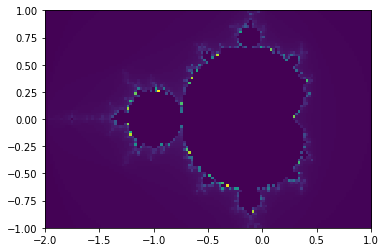

In [3]:
pythonplot(256,128,-2.0,1.0,-1.0,1.0,True);

In [4]:
%timeit pythonplot(xres=512,plot=False);

1.56 s ± 47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Numpy-implementation

In [5]:
def numpyplot(maxi=256,xres=128,xmin=-2.0,xmax=1.0,ymin=-1.0,ymax=1.0,plot=True):
    yres = int(xres * (ymax - ymin) / (xmax - xmin))
    
    # meshgrid takes axis sequences to full matrices
    # (uses Cartesian ordering by default, so we don't need to transpose before plotting)
    x,y = np.meshgrid(np.linspace(xmin,xmax,xres),
                      np.linspace(ymin,ymax,yres))
    c = x + 1j*y
    
    z = np.zeros(x.shape,'complex128')
    
    # by default, points sit in the Mandelbrot set
    escaped = np.zeros(x.shape,'int32')
    
    for it in range(1,maxi):
        # we want to work only with points that haven't escaped yet,
        # so we build a True/False mask for that condition...
        alive = (escaped == 0)
        
        # ...and use it with numpy fancy indexing to apply the
        # Mandelbrot iteration to a subset of the matrices
        z[alive] = z[alive]**2 + c[alive]
        
        # if the point _just_ escaped, save the current iteration,
        escaped[alive & (np.abs(z) > 2)] = it
            
    color = escaped / maxi
    
    if plot:
        plt.imshow(color,interpolation='none',origin='lower',extent=(xmin,xmax,ymin,ymax))
    
    return color

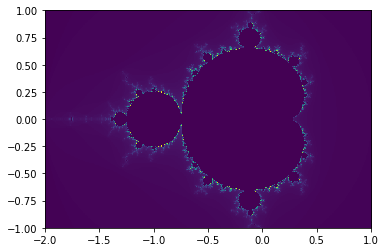

In [6]:
numpyplot(xres=512,plot=True);

In [7]:
%timeit numpyplot(xres=512,plot=False);

461 ms ± 15.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Fortran wrapper with python

In [8]:
%load_ext fortranmagic

In [17]:
%fortran_config

No custom config found for %%fortran
Current defaults arguments for %fortran:
	


In [9]:
%%fortran
subroutine fmand(esc,ny,nx,maxi,xmin,xmax,ymin,ymax)
    implicit none
    integer, intent(in)                                :: ny,nx,maxi
    integer*4, dimension(0:ny-1,0:nx-1), intent(inout) :: esc
    real*8, intent(in)                                 :: xmin, xmax, ymin, ymax

    real*8    :: x,y,dx,dy
    complex*16 :: z,c
    integer   :: i,j,it

    dx = (xmax - xmin)/(nx - 1)
    dy = (ymax - ymin)/(ny - 1)

    do i=0,nx-1
        x = xmin+i*dx
        do j = 0,ny-1
            y = ymin+j*dy
            c = cmplx(x,y)
            z = 0.
            esc(j,i) = 0

            do it=1,maxi-1
                z = z*z + c
                
                if (abs(z)>2.) then
                    esc(j,i) = it
                    exit
                end if
            end do
        end do
    end do

    return
end subroutine fmand

In [10]:
%%fortran -vvv
subroutine fmand(esc,ny,nx,maxi,xmin,xmax,ymin,ymax)
    implicit none
    integer, intent(in)                                :: ny,nx,maxi
    integer*4, dimension(0:ny-1,0:nx-1), intent(inout) :: esc
    real*8, intent(in)                                 :: xmin, xmax, ymin, ymax

    real*8    :: x,y,dx,dy
    complex*16 :: z,c
    integer   :: i,j,it

    dx = (xmax - xmin)/(nx - 1)
    dy = (ymax - ymin)/(ny - 1)

    do i=0,nx-1
        x = xmin+i*dx
        do j = 0,ny-1
            y = ymin+j*dy
            c = cmplx(x,y)
            z = 0.
            esc(j,i) = 0

            do it=1,maxi-1
                z = z*z + c
                
                if (abs(z)>2.) then
                    esc(j,i) = it
                    exit
                end if
            end do
        end do
    end do

    return
end subroutine fmand

Running...
   /home/sunnivin/codework/jupyterlab/.venv/bin/python -m numpy.f2py -m _fortran_magic_85a931a70d8d54e35bc8833a5aff2d8b -c /home/sunnivin/.cache/ipython/fortran/_fortran_magic_85a931a70d8d54e35bc8833a5aff2d8b.f90
running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "_fortran_magic_85a931a70d8d54e35bc8833a5aff2d8b" sources
f2py options: []
f2py:> /tmp/tmpcv28_byu/src.linux-x86_64-3.10/_fortran_magic_85a931a70d8d54e35bc8833a5aff2d8bmodule.c
creating /tmp/tmpcv28_byu/src.linux-x86_64-3.10
Reading fortran codes...
	Reading file '/home/sunnivin/.cache/ipython/fortran/_fortran_magic_85a931a70d8d54e35bc8833a5aff2d8b.f90' (format:free)
Post-processing...
	Block: _fortran_magic_85a931a70d8d54e35bc8833a5aff2d8b
			Block: fmand
Post-processing (stage 2)...
Building modules...


In file included from /home/sunnivin/codework/jupyterlab/.venv/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /home/sunnivin/codework/jupyterlab/.venv/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/sunnivin/codework/jupyterlab/.venv/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /tmp/tmpcv28_byu/src.linux-x86_64-3.10/fortranobject.h:13,
                 from /tmp/tmpcv28_byu/src.linux-x86_64-3.10/fortranobject.c:2:
/home/sunnivin/codework/jupyterlab/.venv/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
In file included from /home/sunnivin/codework/jupyterlab/.venv/lib/python3.10/site-packages/nump


Ok. The following fortran objects are ready to use: fmand


In [11]:
%f2py_help --fcompiler

Gnu95FCompiler instance properties:
  archiver        = ['/usr/bin/gfortran', '-cr']
  compile_switch  = '-c'
  compiler_f77    = ['/usr/bin/gfortran', '-Wall', '-g', '-ffixed-form', '-
                    fno-second-underscore', '-fPIC', '-O3', '-funroll-loops']
  compiler_f90    = ['/usr/bin/gfortran', '-Wall', '-g', '-fno-second-
                    underscore', '-fPIC', '-O3', '-funroll-loops']
  compiler_fix    = ['/usr/bin/gfortran', '-Wall', '-g', '-ffixed-form', '-
                    fno-second-underscore', '-Wall', '-g', '-fno-second-
                    underscore', '-fPIC', '-O3', '-funroll-loops']
  libraries       = ['gfortran']
  library_dirs    = ['/usr/lib/gcc/x86_64-linux-gnu/9', '/usr/lib/gcc/x86_64
                    -linux-gnu/9']
  linker_exe      = ['/usr/bin/gfortran', '-Wall', '-Wall']
  linker_so       = ['/usr/bin/gfortran', '-Wall', '-g', '-Wall', '-g', '-
                    shared']
  object_switch   = '-o '
  ranlib          = ['/usr/bin/gfortran']
  ver

In [12]:
print(fmand.__doc__)

fmand(esc,maxi,xmin,xmax,ymin,ymax,[ny,nx])

Wrapper for ``fmand``.

Parameters
----------
esc : in/output rank-2 array('i') with bounds (ny,nx)
maxi : input int
xmin : input float
xmax : input float
ymin : input float
ymax : input float

Other Parameters
----------------
ny : input int, optional
    Default: shape(esc,0)
nx : input int, optional
    Default: shape(esc,1)



In [13]:
def fortranplot(maxi=256,xres=128,xmin=-2.0,xmax=1.0,ymin=-1.0,ymax=1.0,plot=True):
    yres = int(xres * (ymax - ymin) / (xmax - xmin))
    
    # important! We need to prepare the array with Fortran (column-first) array ordering
    escaped = np.zeros((yres,xres),np.int32,order='F')

    fmand(escaped,maxi,xmin,xmax,ymin,ymax)
    
    color = escaped / maxi
    
    if plot:
        plt.imshow(color,interpolation='none',origin='lower',extent=(xmin,xmax,ymin,ymax))
    
    return color

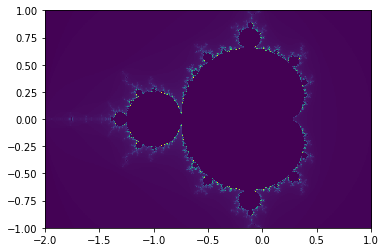

In [14]:
fortranplot(xres=512);

In [15]:
%timeit fortranplot(xres=512,plot=False);

110 ms ± 6.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Compare all implementations against each other


In [16]:
print('Pure python implementation:')
%timeit pythonplot(xres=512,plot=False);
print('')

print('Numpy-python implementation:')
%timeit numpyplot(xres=512,plot=False);
print('')

print('Fortran implementation:')
%timeit fortranplot(xres=512,plot=False);

Pure python implementation:
1.85 s ± 133 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Numpy-python implementation:
545 ms ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Fortran implementation:
120 ms ± 9.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
